## The Goal
- This dataset includes images which contain wildfires and doesn't contain wildfires (see details at: https://www.kaggle.com/datasets/elmadafri/the-wildfire-dataset/data)
- The paper referencing this dataset is: https://www.mdpi.com/1999-4907/14/9/1697
- Our goal is to detect wildfires and avoid confounding variables, current models have problems with false alarm rates.
- Our models are evaluated on accuracy  (probably)

In [33]:

# Cell 1: Imports and Setup
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2  # For image processing
import random
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input, decode_predictions
import gc  # For garbage collection
import cupy as cp
import concurrent.futures
from cupy.linalg import svd


In [23]:
# Cell 2: Utility Functions for Loading and Transforming Images

# Generator function to load images one at a time
def image_generator(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert('RGB')
            img_np = np.array(img)
            yield filename, img_np  # Yield one image at a time

# Function to apply PCA for dimensionality reduction using CuPy (GPU acceleration)
def apply_pca_gpu(image, n_components=50):  # Increased components to 50
    original_shape = image.shape
    reshaped_image = image.reshape(-1, original_shape[-1])  # Flatten the image

    # Convert to CuPy array
    reshaped_image_gpu = cp.array(reshaped_image)

    # Center the data by subtracting the mean
    mean_gpu = cp.mean(reshaped_image_gpu, axis=0)
    centered_image_gpu = reshaped_image_gpu - mean_gpu

    # Perform SVD
    U, S, Vt = svd(centered_image_gpu, full_matrices=False)

    # Select the top n_components
    principal_components_gpu = Vt[:n_components].T

    # Project the data onto the principal components
    transformed_gpu = cp.dot(centered_image_gpu, principal_components_gpu)

    # Reconstruct the data (inverse transform)
    inverse_transformed_gpu = cp.dot(transformed_gpu, principal_components_gpu.T) + mean_gpu
    inverse_transformed = cp.asnumpy(inverse_transformed_gpu)  # Convert back to NumPy

    return inverse_transformed.reshape(original_shape)

# Image enhancement using histogram equalization (optional step)
def enhance_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    enhanced_image = cv2.equalizeHist(gray_image)
    return enhanced_image

# Convert color space from RGB to LAB for better feature representation (optional)
def convert_color_space(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

# Resize image to a fixed size (e.g., 224x224)
def resize_image(image, size=(224, 224)):
    return cv2.resize(image, size)

In [24]:
# Cell 3: Processing the Dataset

# Path to your dataset directory
data_dir = 'Datasets/the_wildfire_dataset_2n_version'
output_dir = 'Processed_Images'  # Define an output directory

# Function to process the dataset (apply transformations and store results)
def process_dataset(data_dir, output_dir, batch_size=10):
    categories = ['fire', 'nofire']
    sets = ['train', 'test']

    for dataset_set in sets:
        for category in categories:
            folder_path = os.path.join(data_dir, dataset_set, category)
            output_path = os.path.join(output_dir, dataset_set, category)
            os.makedirs(output_path, exist_ok=True)
            print(f"Processing {dataset_set}/{category}")

            # Use generator to process images one at a time
            image_gen = image_generator(folder_path)
            batch_images = []
            filenames = []

            for filename, img in image_gen:
                batch_images.append(img)
                filenames.append(filename)

                # When batch size is met, process the batch
                if len(batch_images) == batch_size:
                    process_batch(batch_images, filenames, output_path)
                    batch_images = []
                    filenames = []

            # Process any remaining images after the loop
            if batch_images:
                process_batch(batch_images, filenames, output_path)

            print(f"Finished processing {dataset_set}/{category}")

# Function to process and save a batch of images
def process_batch(batch_images, filenames, output_path):
    # Apply PCA (Dimensionality reduction with GPU acceleration) to each image in the batch
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for i, img in enumerate(batch_images):
            futures.append(executor.submit(process_and_save_image, filenames[i], img, output_path))

        # Ensure all tasks are completed
        concurrent.futures.wait(futures)

# Function to process an individual image (resize, apply color space conversion, PCA, and save)
def process_and_save_image(filename, img, output_path):
    # Resize image to consistent dimensions (e.g., 224x224)
    resized_img = resize_image(img)

    # Convert to LAB color space (optional but can help)
    lab_img = convert_color_space(resized_img)

    # Apply PCA for dimensionality reduction (using GPU acceleration with CuPy)
    pca_img = apply_pca_gpu(lab_img, n_components=50)

    # Clip and convert image to uint8
    processed_img = np.clip(pca_img.astype('uint8'), 0, 255)

    # Save the processed image to disk
    output_file = os.path.join(output_path, filename)
    cv2.imwrite(output_file, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))

# Call the function to process the dataset
process_dataset(data_dir, output_dir)


Processing train/fire
Finished processing train/fire
Processing train/nofire
Finished processing train/nofire
Processing test/fire
Finished processing test/fire
Processing test/nofire


/home/johan/anaconda3/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/johan/anaconda3/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/johan/anaconda3/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Finished processing test/nofire


In [25]:
# Cell 4: Visualizing the Processed Images

# Function to display an image
def display_image(image, title="Image"):
    plt.figure(figsize=(6, 6))  # Adjust figure size for better visualization
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to visualize processed images from disk
def visualize_processed_image(dataset_set, category, filename, output_dir):
    image_path = os.path.join(output_dir, dataset_set, category, filename)

    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        display_image(img_rgb, title=f"{dataset_set}_{category}_{filename}")
    else:
        print(f"No processed image found at path: {image_path}")

# Example: Visualize a specific image (replace 'example_image.jpg' with an actual filename)
visualize_processed_image('train', 'fire', 'example_image.jpg', output_dir)

No processed image found at path: Processed_Images/train/fire/example_image.jpg


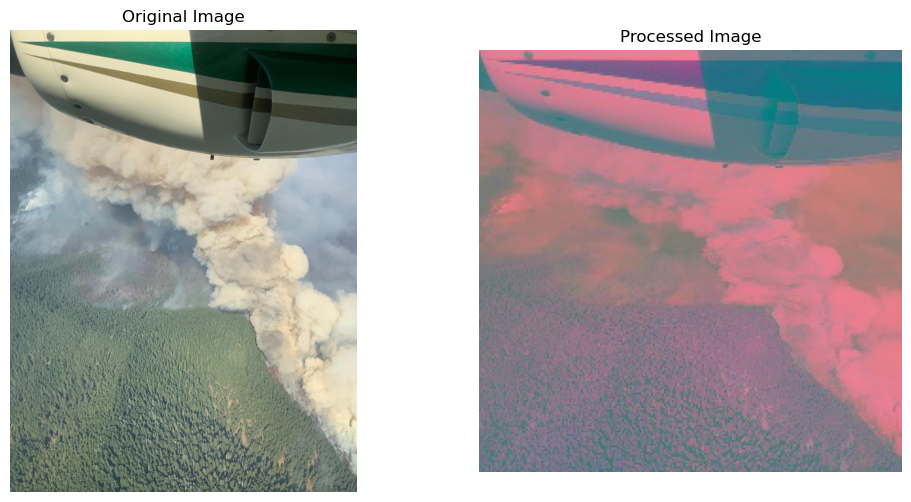

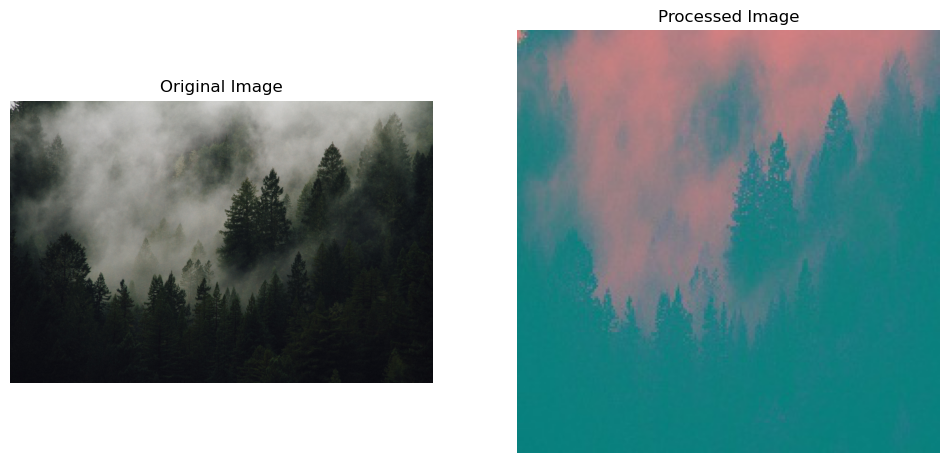

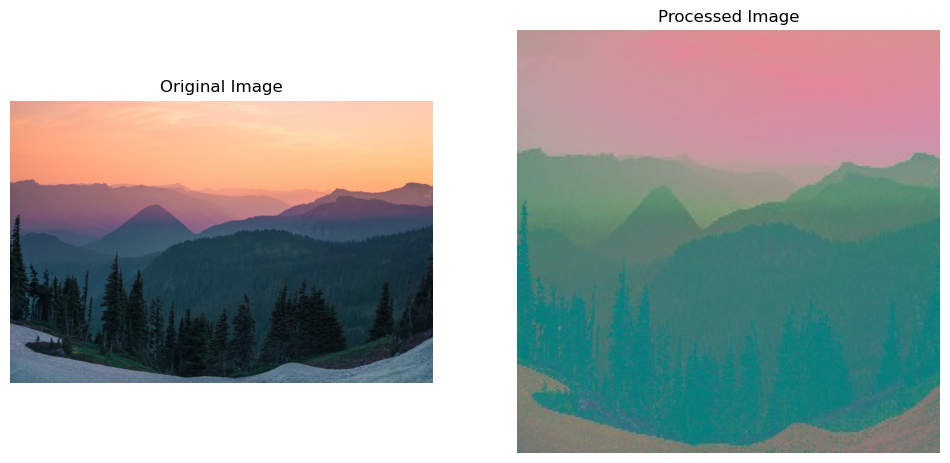

In [38]:
# Function to load an image
def load_image(image_path):
    img = Image.open(image_path).convert('RGB')
    return np.array(img)

# Function to visualize the original and processed images side-by-side
def compare_images(original_image, processed_image, titles=["Original", "Processed"]):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(original_image)
    ax[0].set_title(titles[0])
    ax[0].axis('off')
    
    ax[1].imshow(processed_image)
    ax[1].set_title(titles[1])
    ax[1].axis('off')
    
    plt.show()

# Function to randomly select N images from the dataset
def get_random_images_from_dataset(base_folder, num_images, seed=42):
    np.random.seed(seed)
    random.seed(seed)
    
    # Create a list of all image files in fire and nofire folders for both train and test
    categories = ['fire', 'nofire']
    sets = ['train', 'test']
    all_image_paths = []
    
    for dataset_set in sets:
        for category in categories:
            folder_path = os.path.join(base_folder, dataset_set, category)
            image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]
            full_image_paths = [os.path.join(folder_path, img_file) for img_file in image_files]
            all_image_paths.extend(full_image_paths)
    
    # Randomly select num_images from the list of all image paths
    selected_image_paths = random.sample(all_image_paths, num_images)
    return selected_image_paths

# Function to find the corresponding processed image path
def get_processed_image_path(original_image_path, base_processed_folder):
    # Replace 'Datasets/the_wildfire_dataset_2n_version' with 'Processed_Images' and keep the same structure
    processed_image_path = original_image_path.replace('Datasets/the_wildfire_dataset_2n_version', base_processed_folder)
    return processed_image_path

# Function to load and compare a number of random images with their processed versions
def compare_random_images(base_folder, processed_folder, num_images=1, seed=42):
    # Get random images from the dataset
    random_images = get_random_images_from_dataset(base_folder, num_images, seed)

    # Loop through each selected image
    for original_image_path in random_images:
        # Load the original image
        original_image = load_image(original_image_path)

        # Get the corresponding processed image path
        processed_image_path = get_processed_image_path(original_image_path, processed_folder)

        # Load the processed image
        if os.path.exists(processed_image_path):
            processed_image = load_image(processed_image_path)
        else:
            print(f"Processed image not found for {original_image_path}")
            continue

        # Compare the original and processed images
        compare_images(original_image, processed_image, titles=["Original Image", "Processed Image"])

# Example: Use the function to compare random images
base_folder = 'Datasets/the_wildfire_dataset_2n_version'
processed_folder = 'Processed_Images'

# Compare 3 random images
compare_random_images(base_folder, processed_folder, num_images=3, seed=42)
